# Import Libraries

In [1]:
#for data processing or visualization
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import random
import math

#load data 
import os 

#for deep learning module
import torch 
from torch import nn 
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets
from torchvision import transforms
from segmentation_models_pytorch.losses import DiceLoss

# Configurations

In [23]:
#define the loading list of data
ROOT = '/Users/r/Desktop/git_repository/machine_learning/dataset/UNET-Dataset/'
img_path = ROOT + 'CameraRGB/'
msk_path = ROOT + 'CameraMask/'

#get the directories of image and mask
img_dirs = os.listdir(img_path) 
msk_dirs = os.listdir(msk_path)

#to ensure the mask is corresponding to the correct image
img_dirs = np.sort(img_dirs)
msk_dirs = np.sort(msk_dirs)

img_list = [img_path + i for i in img_dirs]
msk_list = [msk_path + i for i in msk_dirs]

img_list = img_list[1:len(img_list)]
msk_list = msk_list[1:len(msk_list)]

BATCH_SIZE = 8

LOADING = True

LR = 1e-3

EPOCH = 75

IMG_H = 128
IMG_W = 128

DEVICE = 'mps'

# Have a look on the raw image and its mask

Text(0.5, 1.0, 'mask')

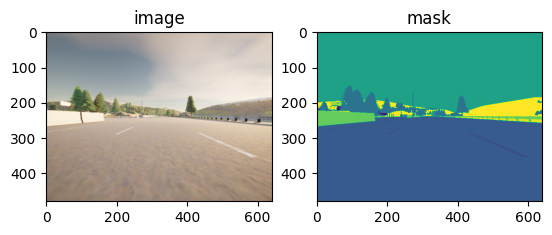

In [3]:
idx = 1
img = plt.imread(img_list[idx])
img = img[:,:,0:3]
msk = plt.imread(msk_list[idx])
msk = msk[:,:,0]

fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(msk)

ax[0].set_title('image')
ax[1].set_title('mask')

In [4]:
train_augs = transforms.Compose([
    transforms.ToTensor()
])

def load_data(img_list, msk_list, new_h, new_w, augs):
    data_list = [None]*len(img_list)
    for i in range(len(img_list)):
        img = plt.imread(img_list[i])
        img = img[:,:,0:3]
        msk = plt.imread(msk_list[i])
        msk = msk[:,:,0]
        img = cv2.resize(img, (new_w, new_h))
        msk = cv2.resize(msk, (new_w, new_h))
        
        img = augs(img)
        msk = augs(msk)*255
        data_list[i] = [img, msk[0,:,:]]
    
    return data_list

data_list = load_data(img_list, msk_list, IMG_H, IMG_W, train_augs)

torch.Size([3, 128, 128]) torch.Size([128, 128])


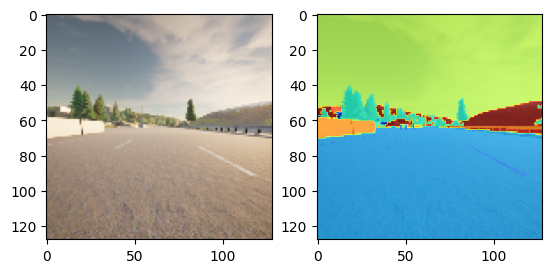

In [5]:
fig, ax = plt.subplots(1, 2)
img, msk = data_list[4]
print(img.shape, msk.shape)

ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(img.permute(1, 2, 0))
ax[1].imshow(msk, cmap = 'jet', alpha = 0.7)

# Split into Training, Validation and Testing Data

In [6]:
def split_ids(data, train=.7, valid=0.1, test=0.2, seed = 0):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test  (float): test split size (between 0 - 1)
    Outputs:
        train_set: list of training data
        valid_set: list of validation data
        test_set: list of testing data
    """
    
    list_copy = list(range(0, len(data)))
    random.Random(seed).shuffle(list_copy)
    
    #obtain the size of training, validation and testing data
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    test_size = len(list_copy) - train_size - valid_size
    
    train_set = [None]*train_size
    if train + valid == 1.0:
        valid_size += test_size
        valid_set = [None]*valid_size
        test_set  = None
        test_size = 0
    else:
        valid_set = [None]*valid_size
        test_set  = [None]*test_size
    
    #split the data into training, validation and testing dataset
    idx = 0
    for cnt, i in enumerate(list_copy):
        
        if cnt == train_size or cnt == train_size + valid_size:
            idx = 0
            
        if cnt < train_size:
            train_set[idx]= [data[i][0], 
                             data[i][1]]
        elif cnt >= train_size and cnt < train_size + valid_size:
            valid_set[idx]= [data[i][0], 
                             data[i][1]]
        else:
            test_set[idx] = [data[i][0], 
                             data[i][1]]
        idx += 1
        
    return train_set, valid_set, test_set

In [7]:
train_data, valid_data, test_data = split_ids(data_list, train = 0.7, valid = 0.15, test = 0.15)

#check if the training and validation dataset are in correct proportion
N_data  = len(data_list)
N_train = len(train_data)
N_valid = len(valid_data)
N_test  = len(test_data)

print(f'Total number of data: {N_data}')
print(f'Total number of training data: {N_train} ({N_train/N_data :.2f})')
print(f'Total number of validation data: {N_valid} ({N_valid/N_data :.2f})')
print(f'Total number of testing data: {N_test} ({N_test/N_data :.2f})')

Total number of data: 1059
Total number of training data: 741 (0.70)
Total number of validation data: 158 (0.15)
Total number of testing data: 160 (0.15)


# Get mini-batch of Training Data

In [8]:
trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = False)
testloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

data_iter = iter(trainloader)

images shape:  torch.Size([8, 3, 128, 128])
masks shape:  torch.Size([8, 128, 128])


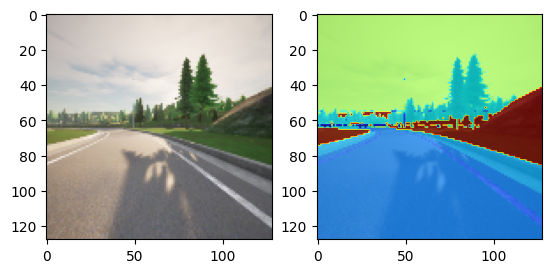

In [9]:
images, masks = next(data_iter)

print('images shape: ', images.shape)
print('masks shape: ', masks.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[0].permute(1,2,0))

ax[1].imshow(images[0].permute(1,2,0))
ax[1].imshow(masks[0,:,:], cmap = 'jet', alpha = 0.7)

# Construct Encoder Blocks

In [10]:
class DownConvBlock(nn.Module):
    def __init__(self, in_c, k_size = (3, 3), p_size = 1):

        '''
        Args:
            in_c: input channel size
            k_size : kernel size
            p_size : padding size
        '''
        
        super(DownConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c*2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv2 = nn.Conv2d(in_channels  = in_c*2, 
                          out_channels = in_c*2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.activation = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
    def forward(self, x):
        
        '''
        Args:
            x: input from upper level
            skip_x : skip input from encoder
        '''
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.max_pool(x)
        
        return x
        

# Construct Decoder Blocks

In [11]:
class UpConvBlock(nn.Module):
    def __init__(self, in_c, k_size = (3, 3), p_size = 1):
        
        '''
        Args:
            in_c: input channel size
            k_size : kernel size
            p_size : padding size
        '''
        
        super(UpConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv2 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv3 = nn.Conv2d(in_channels  = in_c//2, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.activation = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor = 2, 
                                    mode = 'bilinear',
                                    align_corners=True)
        
    def forward(self, x, skip_x):
        
        '''
        Args:
            x: input from lower level
            skip_x : skip input from encoder
        '''
        
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_x], axis = 1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        
        return x
        

# Construct Feature Maps

In [12]:
class FeatureMap(nn.Module):
    def __init__(self, in_c, out_c):
        super(FeatureMap, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_c, 
                              out_channels = out_c, 
                              kernel_size = (1, 1))
    
    def forward(self, x):
        x = self.conv(x)
        return x

# Construct U-Net

In [13]:
class UNet(nn.Module):
    def __init__(self, in_c, out_c, h_c):
        super(UNet, self).__init__()
        self.upfeature = FeatureMap(in_c, h_c)
        self.contract1 = DownConvBlock(h_c)
        self.contract2 = DownConvBlock(h_c*2)
        self.contract3 = DownConvBlock(h_c*4)
        self.contract4 = DownConvBlock(h_c*8) 
        self.expand1 = UpConvBlock(h_c*16)
        self.expand2 = UpConvBlock(h_c*8)
        self.expand3 = UpConvBlock(h_c*4)
        self.expand4 = UpConvBlock(h_c*2)
        self.downfeature = FeatureMap(h_c, out_c)
        
    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3) 
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        out = self.downfeature(x8)
        
        return out

In [14]:
model = UNet(3, 23, 16)
summary(model, (3, IMG_H, IMG_W))
model.to(DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              64
        FeatureMap-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
              ReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
     DownConvBlock-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
             ReLU-12           [-1, 64, 64, 64]               0
        MaxPool2d-13           [-1, 64, 32, 32]               0
    DownConvBlock-14           [-1, 64,

UNet(
  (upfeature): FeatureMap(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contract1): DownConvBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract2): DownConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract3): DownConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padd

In [15]:
#define training loop
def train_fcn(dataloader, model, criterion, opt):
    '''
    Args:
        dataloader: mini-batch of training data
        model     : convolutional neural network
        criterion : loss function for optimization
        opt       : optimizer for updating parameters of neural network
    Outputs:
        avg_loss  : average loss of one training epoch
    '''
    
    
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for (images, labels) in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        opt.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.long())
        preds_max = torch.argmax(preds, dim = 1)
        loss.backward()
        opt.step()

        total_loss += loss.item()
        total_acc += torch.sum(preds_max == labels)/(IMG_H*IMG_W*BATCH_SIZE)

        n += 1
            
    avg_loss = total_loss/n
    avg_acc = total_acc/n

    return avg_loss, avg_acc 

In [16]:
#define training loop
def eval_fcn(dataloader, model, criterion):
    '''
    Args:
        dataloader: mini-batch of training data
        model     : convolutional neural network
        criterion : loss function for optimization
    Outputs:
        avg_loss  : average loss of one evaluation epoch
    '''
    
    
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for (images, labels) in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)
        loss = criterion(preds, labels.long())
        preds_max = torch.argmax(preds, dim = 1)
        total_loss += loss.item()
        total_acc += torch.sum(preds_max == labels)/(IMG_H*IMG_W*BATCH_SIZE)

        n += 1
        
    avg_loss = total_loss/n
    avg_acc = total_acc/n

    return avg_loss, avg_acc 

In [17]:
#define the optimizer
opt = torch.optim.Adam(model.parameters(), lr = LR)
#define the loss
criterion = torch.nn.CrossEntropyLoss()
#initialize best_valid_loss
best_valid_loss = np.Inf

In [25]:
if LOADING:
    #if model has been trained before, load the model parameters
    data = torch.load('best_weights.pt')
    model.load_state_dict(data)
    print("load model successful!")
else:
    #initialize training and validation loss history 
    train_loss_list = [None]*EPOCH
    valid_loss_list = [None]*EPOCH

    #start training 
    for i in range(EPOCH):
        train_loss_list[i], train_acc = train_fcn(trainloader, model, criterion, opt)
        valid_loss_list[i], eval_acc  =  eval_fcn(validloader, model, criterion)

        #save better model with lower validation loss
        print(f'Epoch {i + 1}: ')
        if valid_loss_list[i] < best_valid_loss:
            best_valid_loss =  valid_loss_list[i]
            torch.save(model.state_dict(), 'best_weights.pt')
            print(f'[Found and saved model!]')

        print(f'Training loss: {train_loss_list[i] :.2f}, Validation loss: {valid_loss_list[i] :.2f}')
        print(f'Training acc: {train_acc*100 :.2f}%, Validation acc: {eval_acc*100 :.2f}%')
        torch.save({"state_dict": model.state_dict(), 
                    "train_losses": train_loss_list, 
                    "valid_losses": valid_loss_list}, 
                    'check_pt,pt')

load model successful


# Plot History of Training and Validation Loss 

Text(0, 0.5, 'Loss')

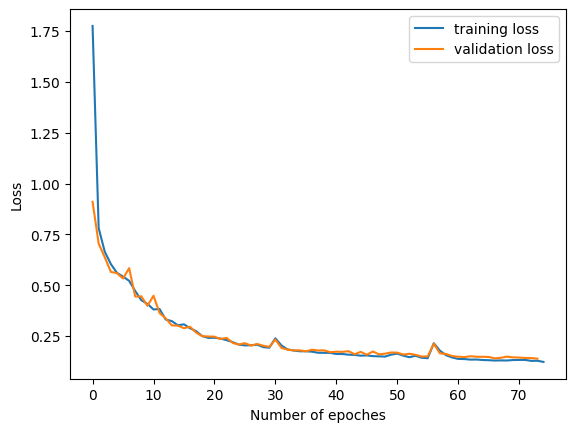

In [19]:
data = torch.load('best_weights.pt')
train_loss_list = data['train_losses']
valid_loss_list = data['valid_losses']

plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Number of epoches')
plt.ylabel('Loss')

# Have a look on the Testing Result

In [20]:
data_iter = iter(validloader)
data = torch.load('best_weights.pt')
model.load_state_dict(data)
model.eval()

UNet(
  (upfeature): FeatureMap(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contract1): DownConvBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract2): DownConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract3): DownConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padd

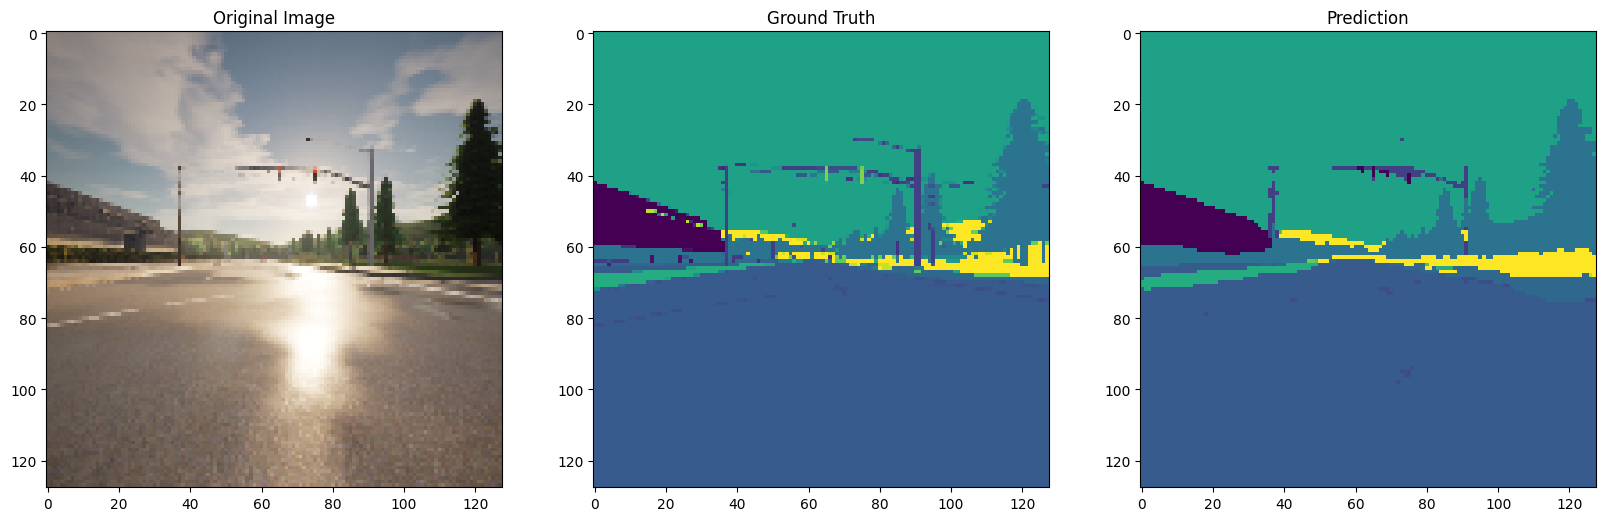

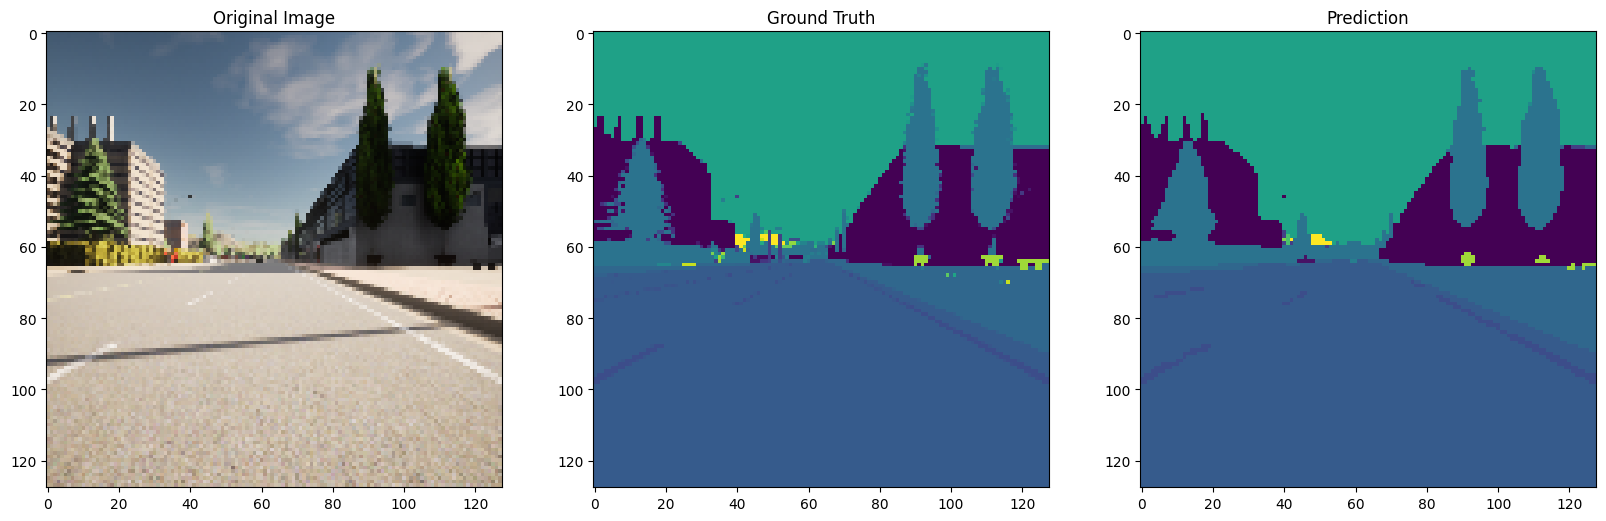

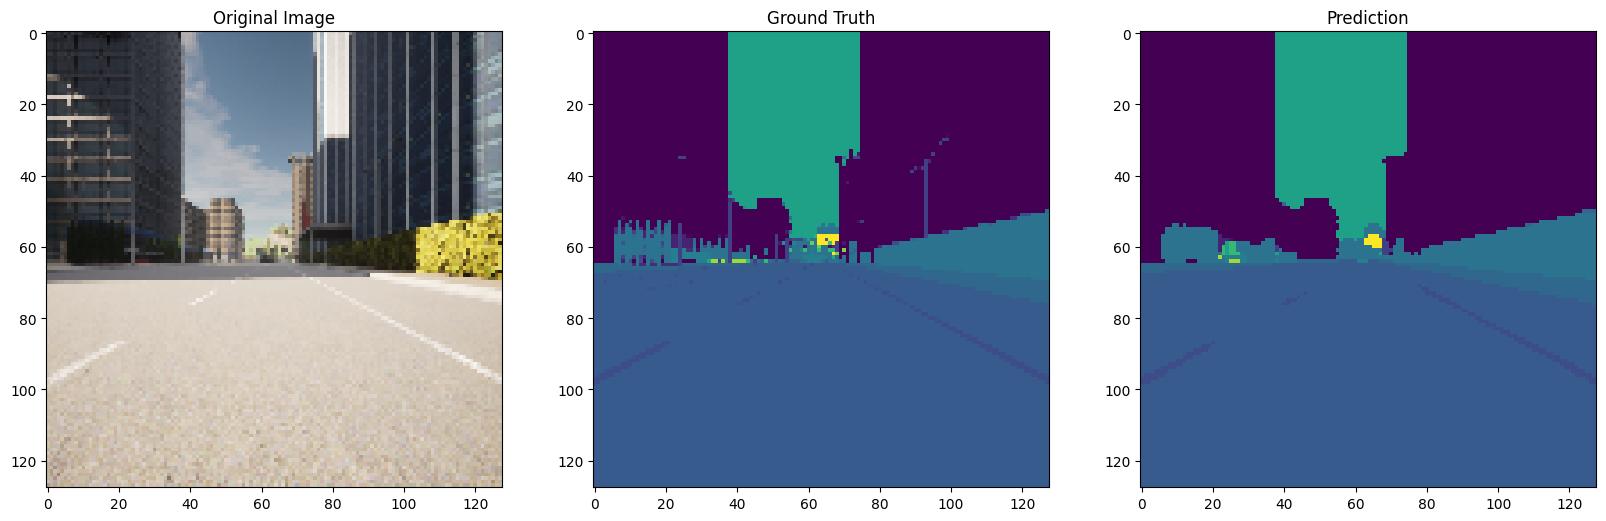

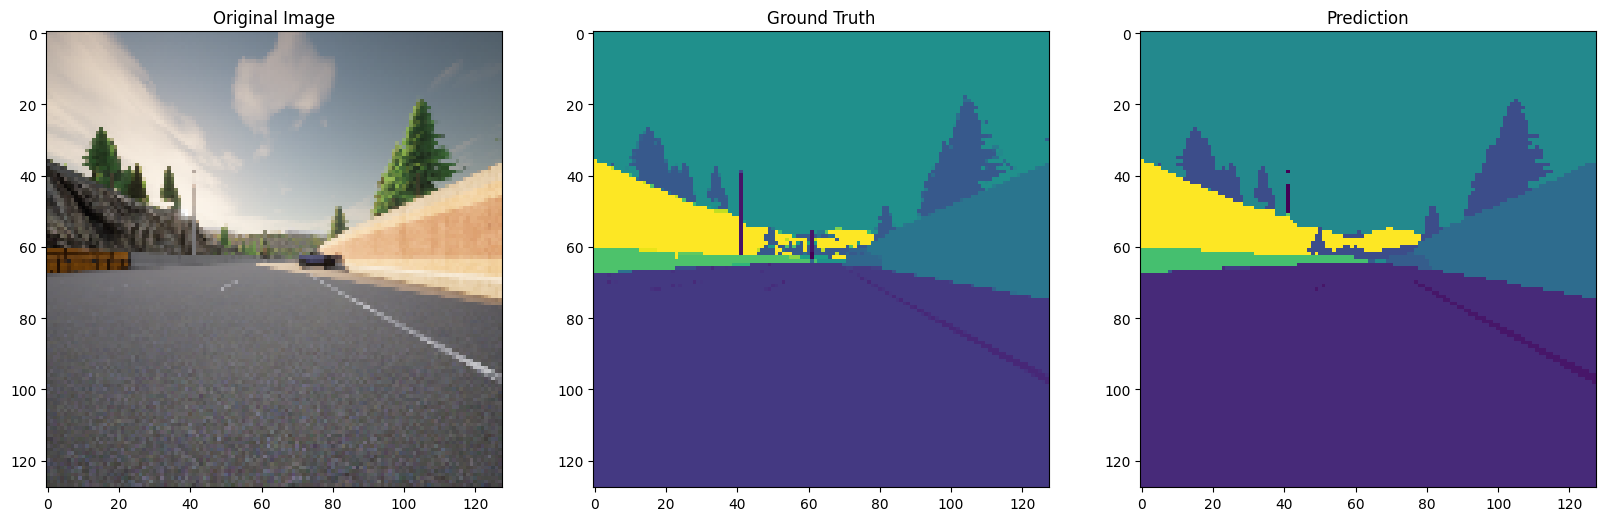

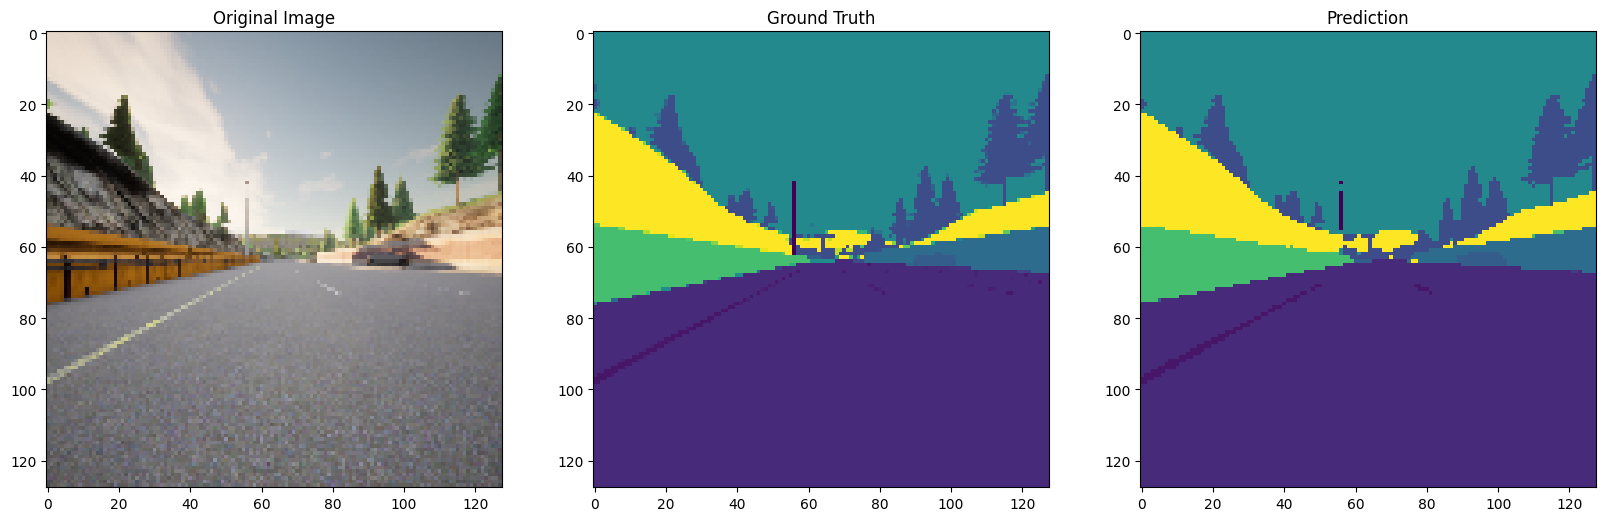

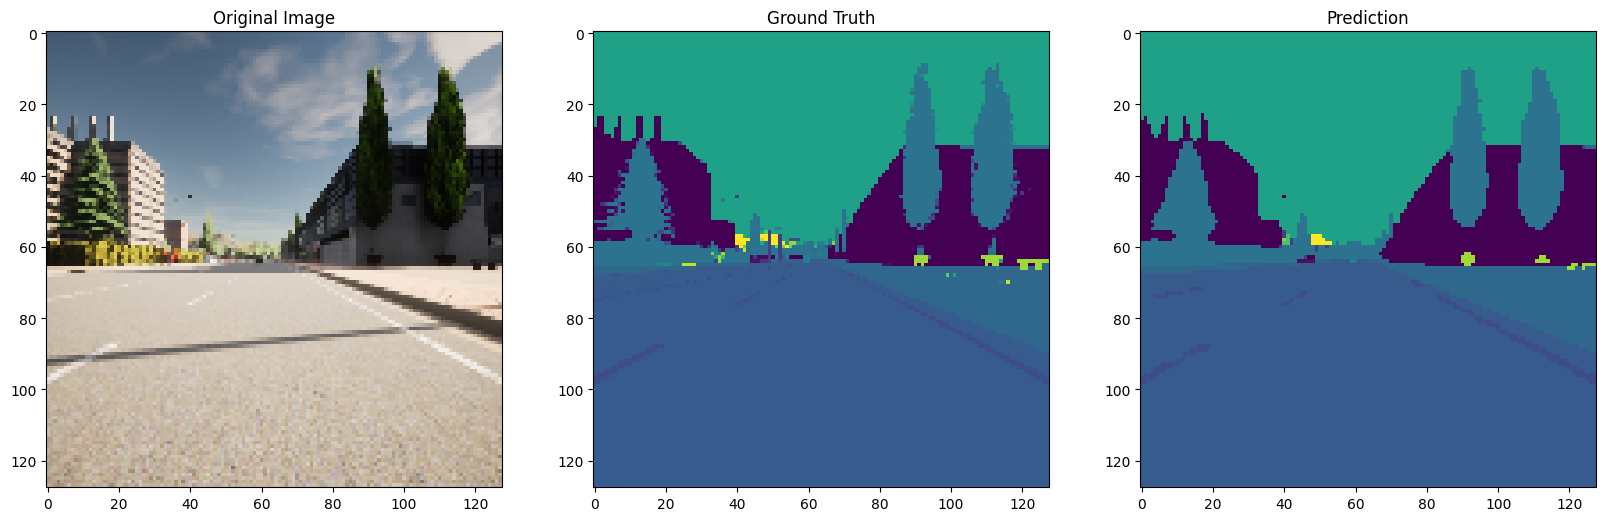

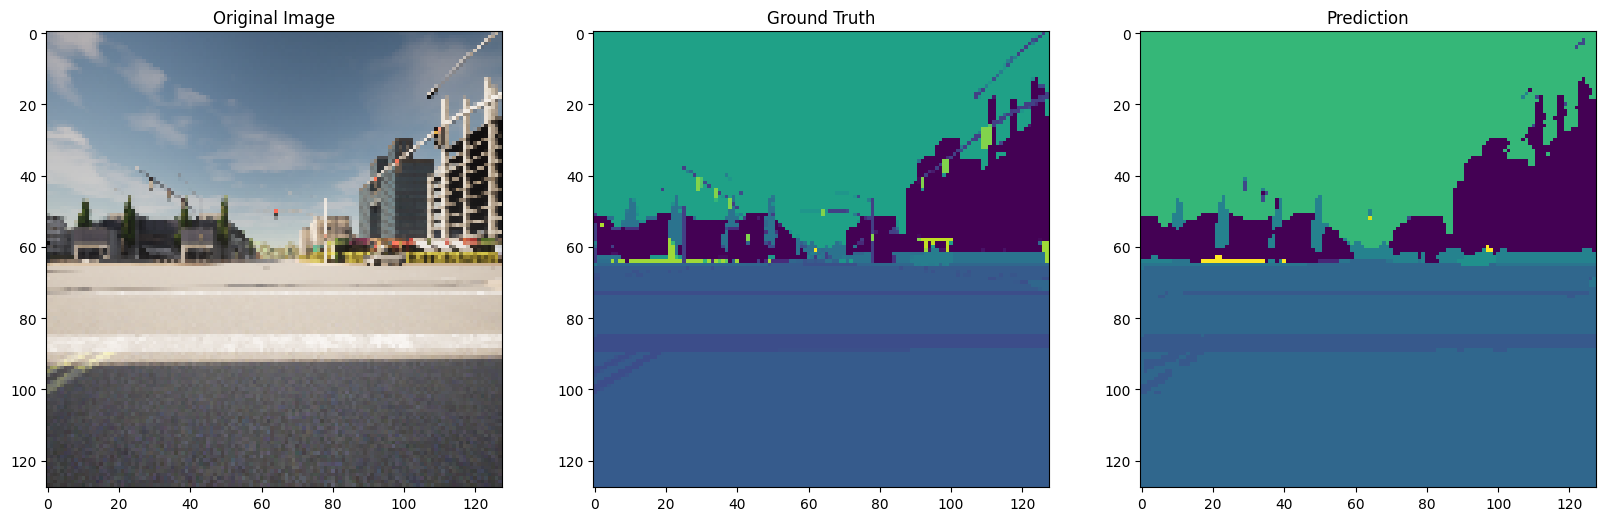

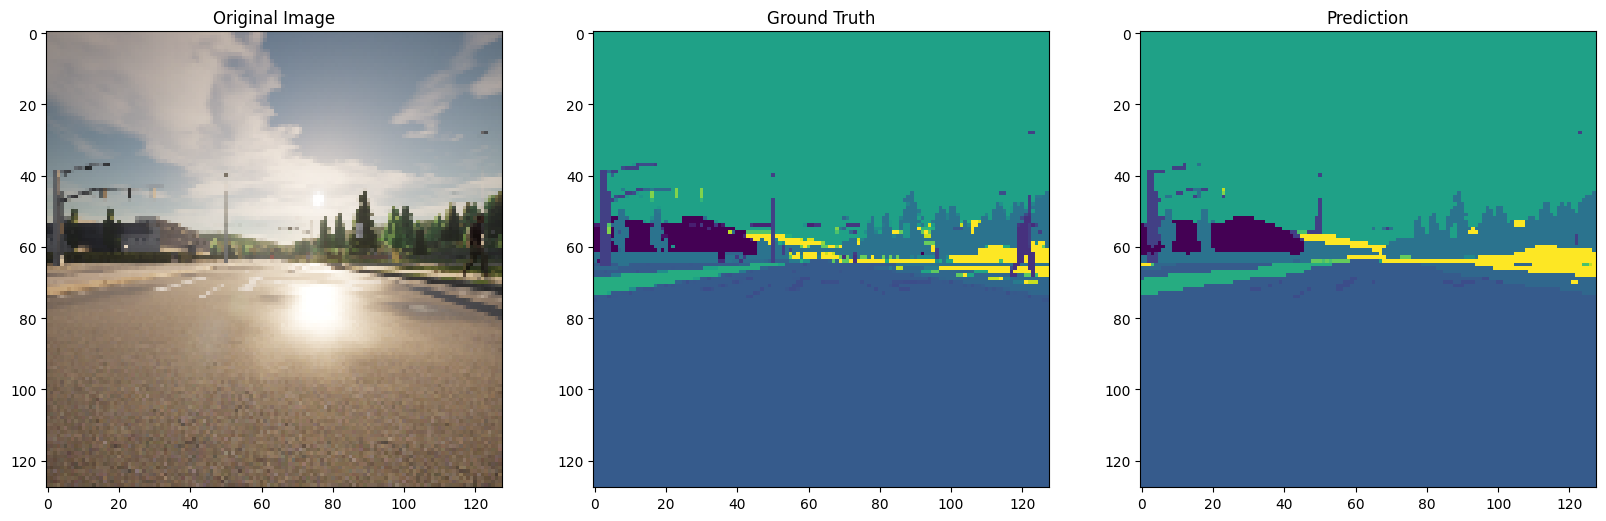

In [21]:
images, masks = next(data_iter)
preds = torch.argmax(model(images.to(DEVICE)), dim = 1, keepdim = True)
for i, image in enumerate(images):
    fig, ax = plt.subplots(1, 3, figsize = (20, 20))
    ax[0].imshow(image.permute(1,2,0))
    ax[1].imshow(masks[i])
    ax[2].imshow(preds[i][0].detach().cpu().numpy())
    
    ax[0].set_title('Original Image')
    ax[1].set_title('Ground Truth')
    ax[2].set_title('Prediction')